In [ ]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# === SHOW ALL COLUMNS ===
pd.set_option('display.max_columns', None)


In [34]:
import os
import pandas as pd

# ✅ Detect environment: Colab or Local
try:
    from google.colab import files
    COLAB = True
except ImportError:
    COLAB = False

if COLAB:
    print("Please upload the dataset manually (creditcard.csv)")
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
else:
    # Local path (if dataset is already in your repo)
    file_name = os.path.join("data", "creditcard.csv")

df = pd.read_csv(file_name)
print(f"✅ Loaded dataset from '{file_name}' successfully!")


Please upload the dataset manually (creditcard.csv)


Saving creditcard.csv to creditcard (2).csv
✅ Loaded dataset from 'creditcard (2).csv' successfully!


In [35]:
# Basic info
df.info()
print("\nShape:", df.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

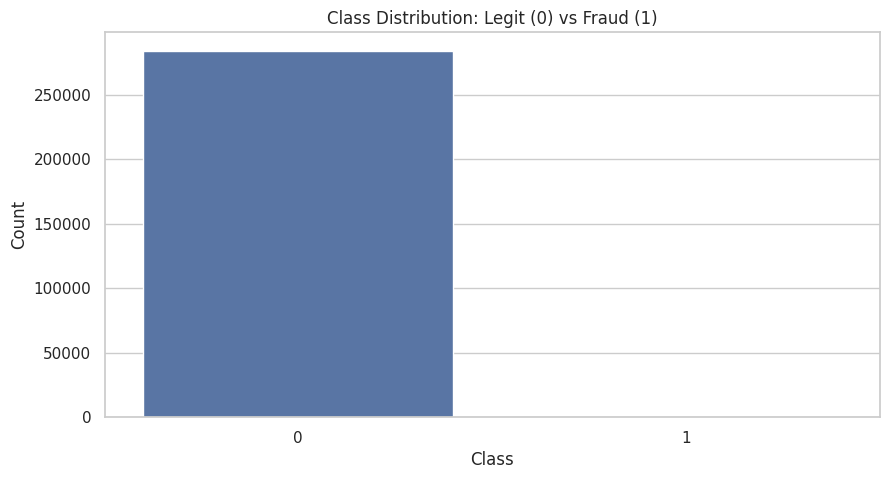

Fraud ratio: 0.1727%


In [36]:
# Fraud vs Non-fraud
fraud_counts = df['Class'].value_counts()
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Class Distribution: Legit (0) vs Fraud (1)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

fraud_ratio = fraud_counts[1] / fraud_counts.sum() * 100
print(f"Fraud ratio: {fraud_ratio:.4f}%")


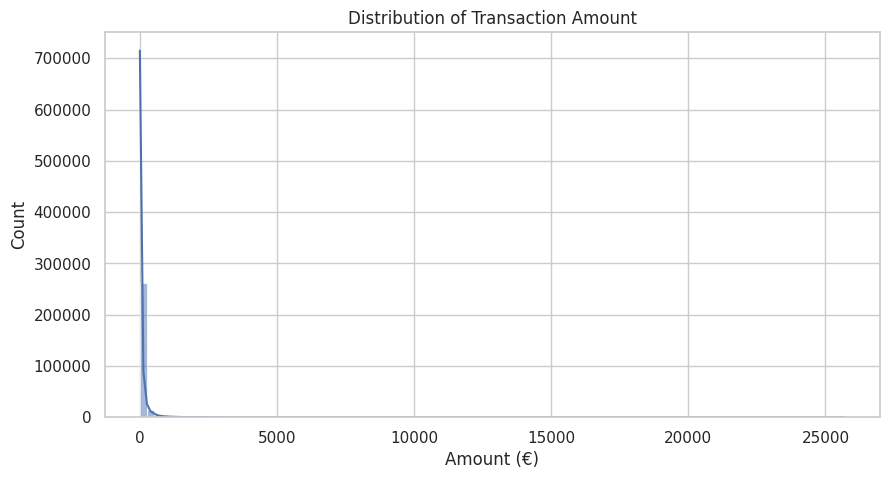

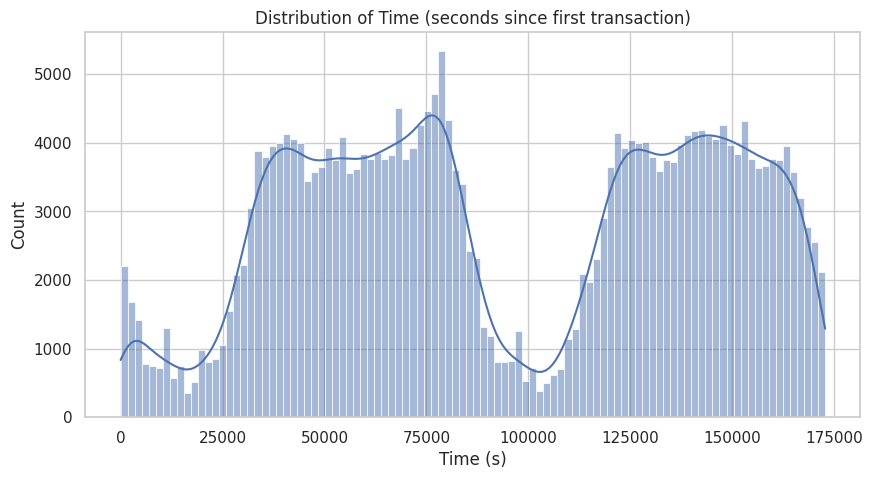

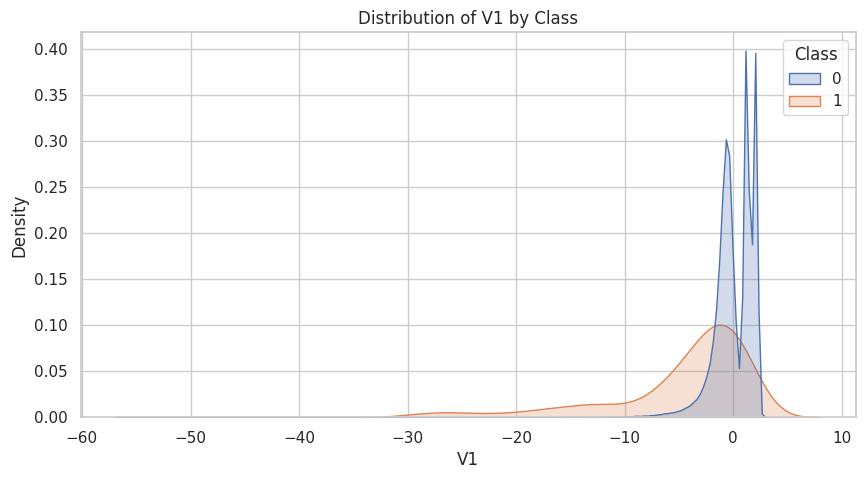

In [37]:
# 💵 Amount distribution
sns.histplot(df['Amount'], bins=100, kde=True)
plt.title("Distribution of Transaction Amount")
plt.xlabel("Amount (€)")
plt.show()

# ⏰ Time distribution
sns.histplot(df['Time'], bins=100, kde=True)
plt.title("Distribution of Time (seconds since first transaction)")
plt.xlabel("Time (s)")
plt.show()

# ⚡ PCA Feature by Class
sns.kdeplot(data=df, x="V1", hue="Class", fill=True, common_norm=False)
plt.title("Distribution of V1 by Class")
plt.show()


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Scale only 'Time' and 'Amount' (others already PCA)
scaler = StandardScaler()
for col in ['Time', 'Amount']:
    X_train[col] = scaler.fit_transform(X_train[[col]])
    X_test[col]  = scaler.transform(X_test[[col]])

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Fraud ratio train:", y_train.mean()*100, "%")


Train: (227845, 30) Test: (56962, 30)
Fraud ratio train: 0.17292457591783889 %


After SMOTE: Class
0    227451
1     45490
Name: count, dtype: int64


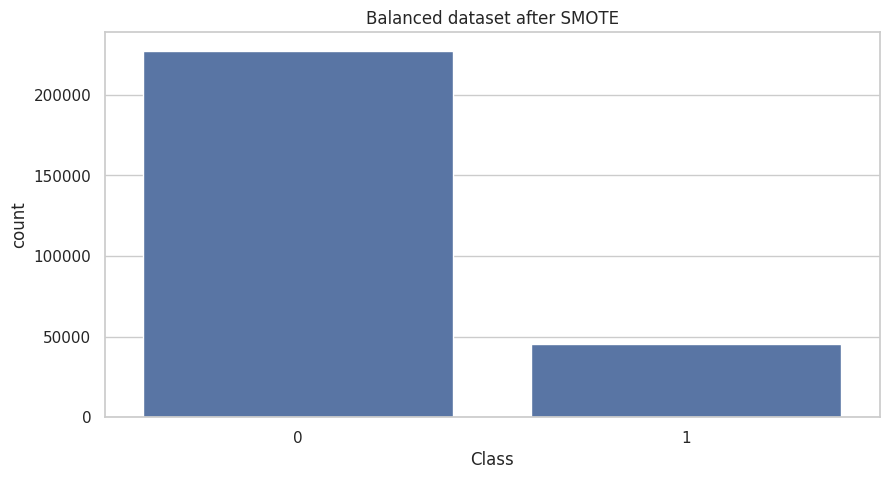

In [39]:
from imblearn.over_sampling import SMOTE

#
smote = SMOTE(random_state=42, sampling_strategy=0.2)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE:", y_train_res.value_counts())
sns.countplot(x=y_train_res)
plt.title("Balanced dataset after SMOTE")
plt.show()


In [40]:
# === MODEL EVALUATION UTILITIES ===
# This cell defines AND confirms the functions are loaded correctly 👇

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    RocCurveDisplay, PrecisionRecallDisplay, fbeta_score
)

def evaluate_model(model, Xtr, ytr, Xte, yte, name=None, threshold=0.5):
    """
    Train a classification model and show key metrics + visualizations.
    - model: sklearn or XGBoost model with .fit() and .predict_proba()
    - threshold: probability cutoff for class 1 (fraud)
    """
    if name is None:
        name = model.__class__.__name__

    print(f"\n🚀 Training {name}...")
    model.fit(Xtr, ytr)
    proba = model.predict_proba(Xte)[:, 1]
    y_pred = (proba >= threshold).astype(int)

    # === METRICS ===
    print(f"\n=== {name} (threshold={threshold:.2f}) ===")
    print(classification_report(yte, y_pred, digits=4))
    print("ROC-AUC:", round(roc_auc_score(yte, proba), 4))

    # === CONFUSION MATRIX ===
    cm = confusion_matrix(yte, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # === ROC CURVE ===
    RocCurveDisplay.from_predictions(yte, proba)
    plt.title(f"ROC Curve — {name}")
    plt.show()

    # === PRECISION-RECALL CURVE ===
    PrecisionRecallDisplay.from_predictions(yte, proba)
    plt.title(f"Precision-Recall — {name}")
    plt.show()

    return proba


def find_best_threshold(y_true, proba, beta=2.0):
    """
    Find the best classification threshold maximizing the F-beta score.
    beta > 1 means we value Recall more than Precision.
    """
    ts = np.linspace(0.01, 0.99, 99)
    scores = [(t, fbeta_score(y_true, (proba>=t).astype(int), beta=beta)) for t in ts]
    best_t, best_s = max(scores, key=lambda x: x[1])
    print(f"✅ Best threshold for F{beta}: {best_t:.2f} (score={best_s:.4f})")
    return best_t


# === Confirm everything is loaded correctly ===
print("✅ Functions 'evaluate_model()' and 'find_best_threshold()' are ready to use!")


✅ Functions 'evaluate_model()' and 'find_best_threshold()' are ready to use!



🚀 Training Logistic Regression...

=== Logistic Regression (threshold=0.50) ===
              precision    recall  f1-score   support

           0     0.9998    0.9942    0.9970     56864
           1     0.2076    0.8878    0.3366        98

    accuracy                         0.9940     56962
   macro avg     0.6037    0.9410    0.6668     56962
weighted avg     0.9984    0.9940    0.9958     56962

ROC-AUC: 0.967


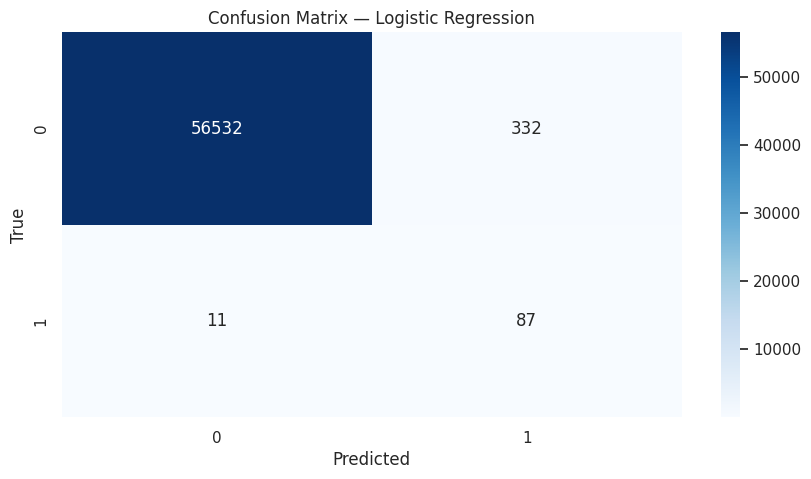

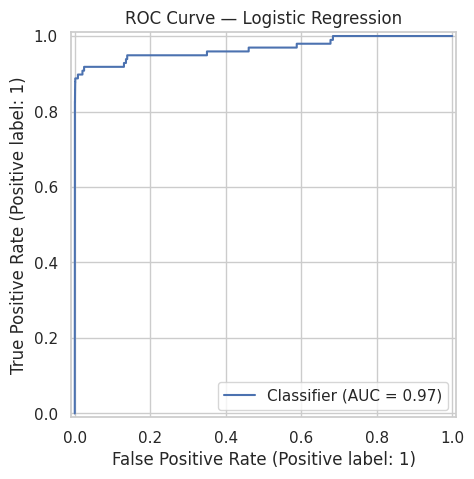

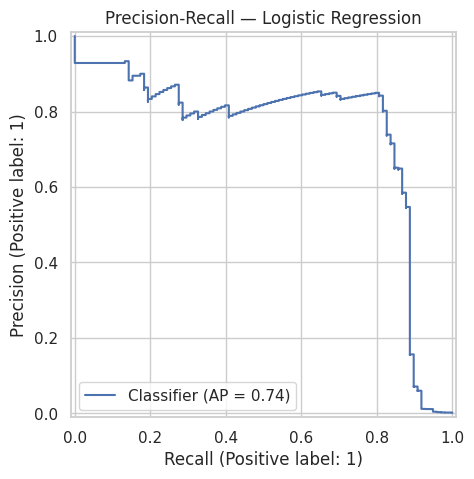

✅ Best threshold for F2.0: 0.99 (score=0.8169)

🚀 Training Logistic Regression (tuned)...

=== Logistic Regression (tuned) (threshold=0.99) ===
              precision    recall  f1-score   support

           0     0.9997    0.9994    0.9996     56864
           1     0.7155    0.8469    0.7757        98

    accuracy                         0.9992     56962
   macro avg     0.8576    0.9232    0.8876     56962
weighted avg     0.9992    0.9992    0.9992     56962

ROC-AUC: 0.967


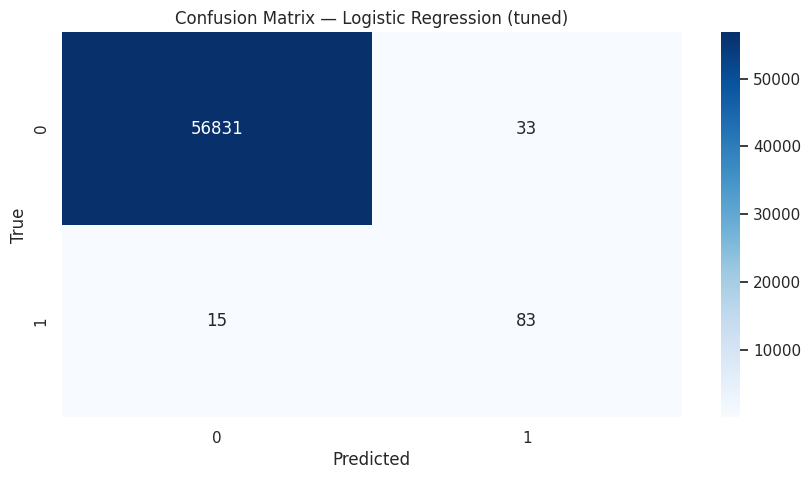

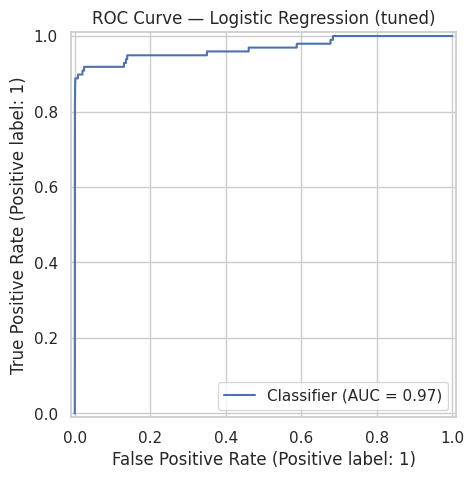

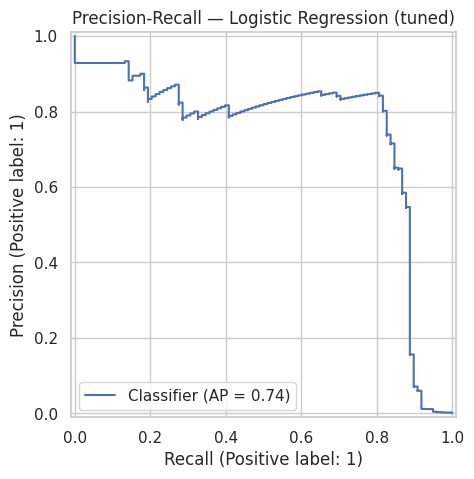

In [41]:
from sklearn.linear_model import LogisticRegression

# 🧱 Define baseline model
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)

# 🚀 Train & evaluate
proba_lr = evaluate_model(
    log_reg,
    X_train_res, y_train_res,
    X_test, y_test,
    name="Logistic Regression"
)

# 🎯 Find the optimal threshold (F2-score → Recall is more important)
t_star = find_best_threshold(y_test, proba_lr, beta=2.0)

# 🔁 Re-evaluate with tuned threshold
_ = evaluate_model(
    log_reg,
    X_train_res, y_train_res,
    X_test, y_test,
    name="Logistic Regression (tuned)",
    threshold=t_star
)



🚀 Training Random Forest...

=== Random Forest (threshold=0.50) ===
              precision    recall  f1-score   support

           0     0.9998    0.9994    0.9996     56864
           1     0.7241    0.8571    0.7850        98

    accuracy                         0.9992     56962
   macro avg     0.8619    0.9283    0.8923     56962
weighted avg     0.9993    0.9992    0.9992     56962

ROC-AUC: 0.98


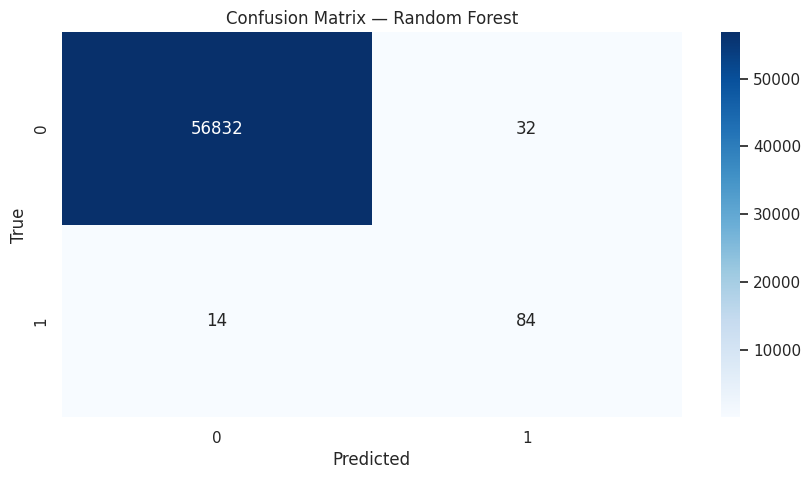

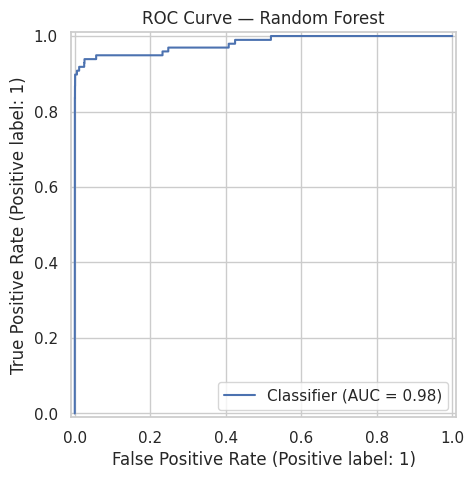

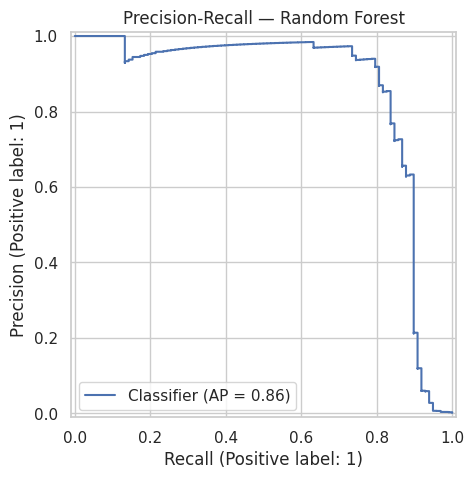

In [42]:
from sklearn.ensemble import RandomForestClassifier

# 🌲 Random Forest (optimized for speed)
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)

proba_rf = evaluate_model(
    rf,
    X_train_res, y_train_res,
    X_test, y_test,
    name="Random Forest"
)



🚀 Training XGBoost...

=== XGBoost (threshold=0.50) ===
              precision    recall  f1-score   support

           0     0.9998    0.9985    0.9991     56864
           1     0.5030    0.8571    0.6340        98

    accuracy                         0.9983     56962
   macro avg     0.7514    0.9278    0.8166     56962
weighted avg     0.9989    0.9983    0.9985     56962

ROC-AUC: 0.9777


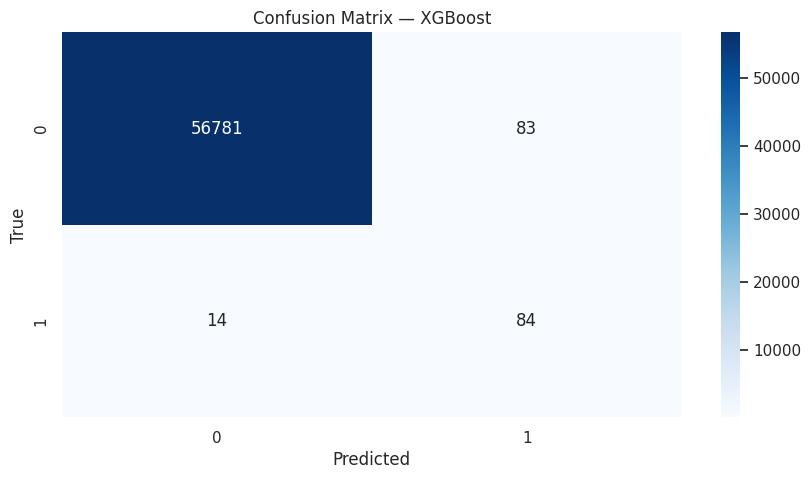

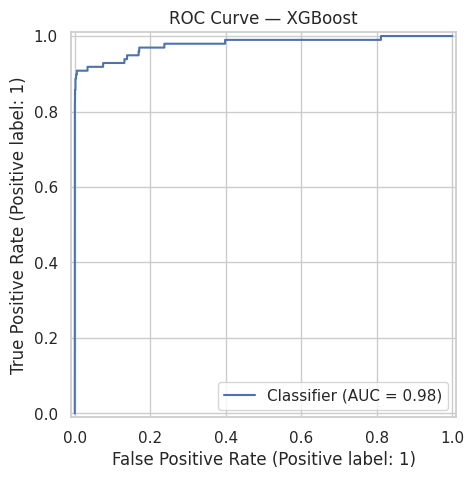

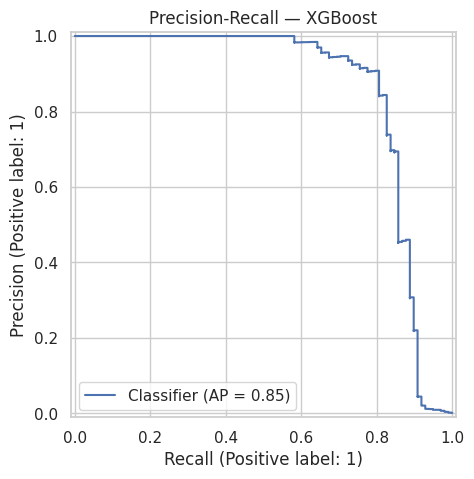

In [43]:
from xgboost import XGBClassifier

# ⚡ XGBoost tuned for balanced performance
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=42,
    eval_metric="logloss"
)

proba_xgb = evaluate_model(
    xgb,
    X_train_res, y_train_res,
    X_test, y_test,
    name="XGBoost"
)


In [44]:
# Simple summary table
from sklearn.metrics import precision_score, recall_score, f1_score

models = {
    "LogisticRegression": (log_reg, proba_lr),
    "RandomForest": (rf, proba_rf),
    "XGBoost": (xgb, proba_xgb),
}

summary = []
for name, (model, proba) in models.items():
    y_pred = (proba >= 0.5).astype(int)
    summary.append({
        "Model": name,
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, proba)
    })

pd.DataFrame(summary).sort_values("AUC", ascending=False)


,Model,Precision,Recall,F1,AUC
1,RandomForest,0.724138,0.857143,0.785047,0.979961
2,XGBoost,0.502994,0.857143,0.633962,0.977715
0,LogisticRegression,0.207637,0.887755,0.336557,0.966987


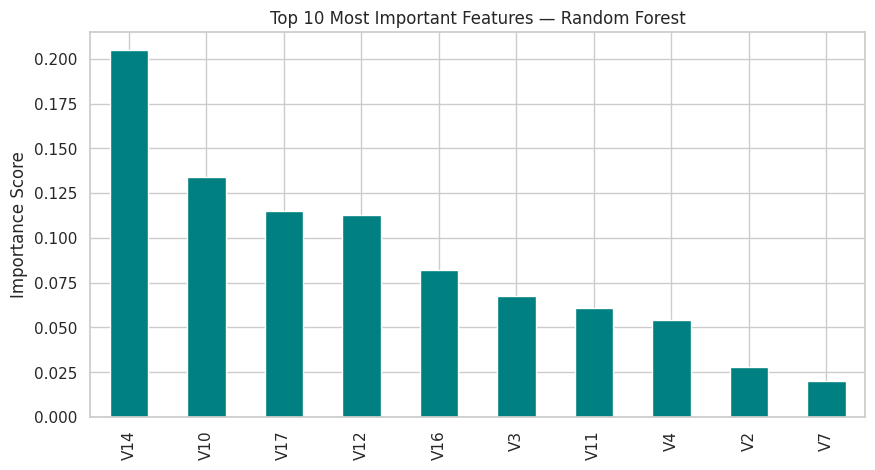

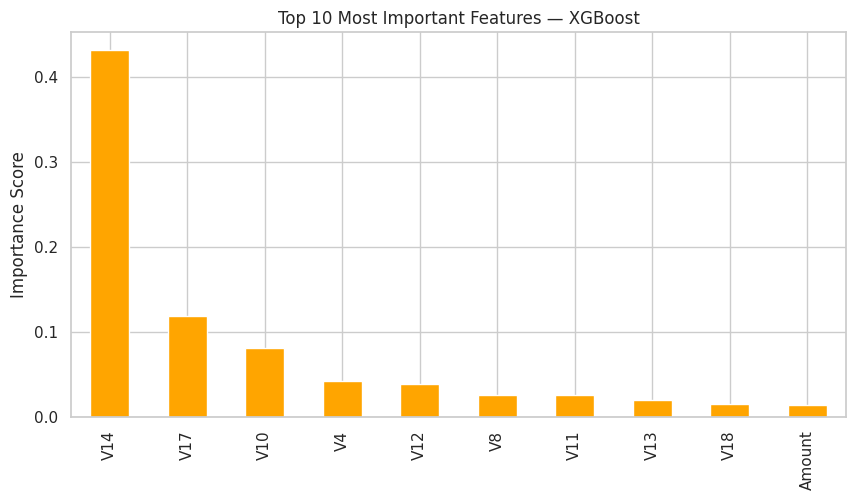

In [45]:
# === FEATURE IMPORTANCE ===
import matplotlib.pyplot as plt
import pandas as pd

# Random Forest Feature Importance
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances.head(10).plot(kind='bar', color='teal')
plt.title("Top 10 Most Important Features — Random Forest")
plt.ylabel("Importance Score")
plt.show()

# XGBoost Feature Importance
xgb_importances = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
xgb_importances.head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Most Important Features — XGBoost")
plt.ylabel("Importance Score")
plt.show()


In [49]:
# === FEATURE IMPORTANCE EXPORTS ===
import os

# ✅ Fix path for both Colab and Local
reports_dir = os.path.join(os.getcwd(), "reports")
os.makedirs(reports_dir, exist_ok=True)

# === Save CSV reports ===
results_path = os.path.join(reports_dir, "model_summary.csv")
rf_path = os.path.join(reports_dir, "feature_importance_rf.csv")
xgb_path = os.path.join(reports_dir, "feature_importance_xgb.csv")

# build dataframe before saving
results_df = pd.DataFrame(summary).sort_values("AUC", ascending=False)

# export
results_df.to_csv(results_path, index=False)
importances.to_csv(rf_path, header=["importance"])
xgb_importances.to_csv(xgb_path, header=["importance"])

print(f"📊 Reports saved to: {os.path.abspath(reports_dir)}")

# === Detect if running in Google Colab ===
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# === If Colab: download files directly ===
if IN_COLAB:
    from google.colab import files
    print("⬇️ Downloading reports to your computer...")
    files.download(results_path)
    files.download(rf_path)
    files.download(xgb_path)
else:
    print("✅ Running locally — files exported to /reports folder.")


📊 Reports saved to: /content/reports
⬇️ Downloading reports to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>